In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Gradient Descent

Simple Gradient Descent involves starting from an arbitrary point, and moving in the direction opposite to the maximum gradient

$$\begin{align}
&{\rm algorithm\; G{\scriptsize RADIENT}\text{-D}{\scriptsize ESCENT}}\; (\theta^{(0)}, \eta, \mathcal{L}):\\
&t \leftarrow 0 \\
&\text{do} \\
&\quad \theta^{(t+1)} \leftarrow \theta^{(t)} - \eta \; \nabla_\theta \mathcal{L}(\theta^{(t)}) \\
&\quad t \leftarrow t+1 \\
&\text{while not converged} \\
&\text{return }\theta^{(t)} 
\end{align}
$$

$\eta$ defines the learning rate, while $\mathcal{L}$ is the loss function

Here, we do a simple univariate regression on a random sample from the [Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant). 

In [3]:
ccpp_all_samples = pd.read_csv('../data/CCPP/output.csv')
ccpp_all_samples.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [4]:
df = ccpp_all_samples.sample(500)
df.head()

,AT,V,AP,RH,PE
4696,20.03,60.77,1017.23,87.82,449.31
7540,22.22,66.05,1016.15,80.58,442.95
6577,23.25,59.87,1018.69,66.40,444.23
4500,17.94,37.20,1012.64,68.11,467.65
7988,12.07,40.81,1025.63,68.02,475.96


In [5]:
x = df['AT'].to_numpy()
y = df['PE'].to_numpy()
#y = (y - y.mean())/y.std()
#x = (x - x.mean())/x.std()

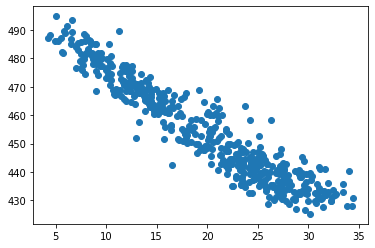

In [6]:
plt.scatter(x,y)

Data seems nice: simple, linearly dependent and homoscedastic. Let's make a loss function for this

In [7]:
def loss(x, y, theta_0, theta_1):
    return (((y-theta_0-theta_1*x)**2)/(2*len(y))).sum()

def grad_loss(x, y, theta_0, theta_1):
    return (-(y-theta_0-theta_1*x).mean(),(-x*(y-theta_0-theta_1*x)).mean())

def grad_loss_0(x, y, theta_0, theta_1):
    return -(y-theta_0-theta_1*x).mean()

def grad_loss_1(x, y, theta_0, theta_1):
    return (-x*(y-theta_0-theta_1*x)).mean()

And now plot the contours so we get an idea of our parameters

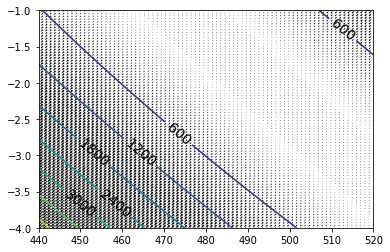

In [8]:
theta_0_space = np.linspace(440,520,80)
theta_1_space = np.linspace(-4,-1,80)
theta_space   = np.meshgrid(theta_0_space, theta_1_space)

vector_loss = np.vectorize(loss, signature='(m),(m),(),()->()')
loss_space = vector_loss(x, y, theta_space[0], theta_space[1])
vector_grad_loss_0 = np.vectorize(grad_loss_0, signature='(m),(m),(),()->()')
vector_grad_loss_1 = np.vectorize(grad_loss_0, signature='(m),(m),(),()->()')
grad_loss_space_0 = vector_grad_loss_0(x, y, theta_space[0], theta_space[1])
grad_loss_space_1 = vector_grad_loss_1(x, y, theta_space[0], theta_space[1])

CS = plt.contour(theta_0_space, theta_1_space, loss_space)
plt.clabel(CS, fmt = '%2.1d', colors = 'k', fontsize=14) #contour line labels
plt.quiver(theta_0_space,theta_1_space,grad_loss_space_0,grad_loss_space_1)

In [9]:
# now the GD algo
def gradient_descent(x, y, theta_0, theta_1, eta, t_lim=1000):
    
    theta_0_pts = [theta_0]
    theta_1_pts = [theta_1]
    
    t = 0
    
    while t < t_lim:
        loss_grad = grad_loss(x,y,theta_0_pts[-1], theta_1_pts[-1])
        #print(loss_grad)
        theta_0_n = theta_0_pts[-1] - eta*loss_grad[0]
        theta_1_n = theta_1_pts[-1] - eta*loss_grad[1]
        
        if (abs(theta_0_n-theta_0_pts[-1]) < 0.00001 and abs(theta_1_n-theta_1_pts[-1]) < 0.00001):
            break
        
        theta_0_pts.append(theta_0_n)
        theta_1_pts.append(theta_1_n)
        
        t += 1
            
    return (theta_0_pts, theta_1_pts)

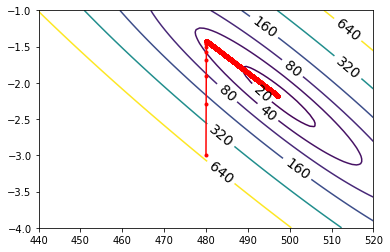

In [10]:
levels = [10,20,40,80,160,320,640]
CS = plt.contour(theta_0_space, theta_1_space, loss_space, levels=levels)
plt.clabel(CS, fmt = '%2.1d', colors = 'k', fontsize=14)

gd_pts = gradient_descent(x,y,480,-3,0.001,t_lim=100000)
plt.plot(gd_pts[0], gd_pts[1], color='r', marker='.')
plt.savefig('grad_not_perp.png')

Note that the gradient descent _need not be parallel to the visible gradient always!_ See [Goodfellow et al, Chp4](https://www.deeplearningbook.org/contents/numerical.html). Note that our parameter space seems like a simple elliptic paraboloid, but it's a bit more complicated; rather than two, this one has 500 axes (for different values of $y^{(i)}$ and $x^{(i)}$). A gradient descent on a paraboloid fitted to the data would give a much more _neater_ descent, where it would run parallel to the gradients neatly. Here's an example:

In [15]:
# points to fit
ts_pts = np.dstack([theta_space[0].ravel(), theta_space[1].ravel()])
fit_pts = loss_space.ravel()

# model = (y-a-bx)^2 + (y-d-ex)^2 + c, find a,b,c,d,e,
# TODO make the fit equations for this 
# hmm... generalized curve fitting! Revise bishop.


array([[4436.4234045 , 4342.70041626, 4250.00290471, ...,  220.29809458,
         205.5368112 ,  191.8010045 ],
       [4363.30744498, 4270.34188613, 4178.40180396, ...,  205.50419781,
         191.50034381,  178.5219665 ],
       [4290.83120973, 4198.62308026, 4107.44042748, ...,  191.3500253 ,
         178.10360069,  165.88265277],
       ...,
       [ 678.3277296 ,  642.92680411,  608.5513553 , ...,  953.00125115,
         996.56203052, 1041.14828657],
       [ 654.47053872,  619.82704261,  586.20902319, ...,  987.46612301,
        1031.78433176, 1077.1280172 ],
       [ 631.2530721 ,  597.36700538,  564.50641535, ..., 1022.57071914,
        1067.64635728, 1113.7474721 ]])